In [1]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../')

import numpy as np
import torch
import matplotlib.pyplot as plt

from drawing import draw_window, visualize_score_map
from image import get_image_tensor, get_numpy_image
from shape import Window, Position
from roi_align import RoIAlignFeatureExtractor
from image import load_image
from feature_extractor import CNN, ReCNN, ResizeImageFeatureExtractor, FeatureExtractor, EdgeImageFeatureExtractor
from candidates import Candidates
from scorer import CosineSimilarityScorer, Scorer
from shape.basic import Size
from utils.timer import timer

def visualize_result(img: np.ndarray, score_map: np.ndarray, threshold: float, rois: Candidates, best_window: Window, scores: torch.Tensor):
    fig, axes = plt.subplots(1, 4, figsize=(20, 3))
    axes[0].imshow(img)
    axes[1].imshow(score_map)
    axes[2].imshow(score_map > threshold)

    windows = rois.rois.cpu().numpy()
    best_pos_indices = (windows[:, 1] == best_window.cx) & (windows[:, 2] == best_window.cy)
    best_pos_windows = windows[best_pos_indices]
    best_pos_scores = scores.reshape(-1)[best_pos_indices].cpu().numpy()
    angles = best_pos_windows[:, 5]
    axes[3].plot(angles, best_pos_scores)
    axes[3].set_xlabel('angle')
    axes[3].set_ylabel('score')
    axes[3].set_ylim(0.0, 1.0)
    plt.show()

Text(0.5, 1.0, 'target')

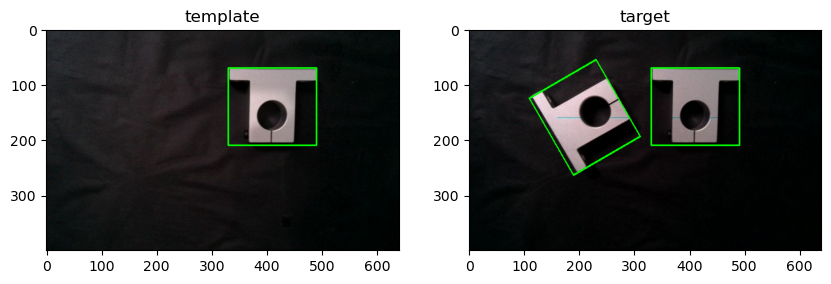

In [2]:
target_img = load_image('../data/image_1.png')
template_img = load_image('../data/template_1.jpg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

template_window = Window(410., 140., 160., 140., 0)
draw_img = draw_window(template_img, template_window)
axes[0].imshow(draw_img)
axes[0].set_title('template')

target_windows = [
    Window(210, 160, 160, 140, -120),
    Window(410., 140., 160., 140., 0)
    ]
draw_img = target_img.copy()
for target_window in target_windows:
    draw_img = draw_window(draw_img, target_window)
axes[1].imshow(draw_img)
axes[1].set_title('target')

In [3]:
from matcher import NaiveMatcher, SearchParams

roi_feature_extractor = RoIAlignFeatureExtractor(output_size=7, sampling_ratio=2)
scorer = CosineSimilarityScorer()
feature_extractor = EdgeImageFeatureExtractor('canny')
search_params = SearchParams(x_step=4, y_step=4, angle_step=10, score_threshold=0.5, iou_threshold=0.1)
matcher = NaiveMatcher(feature_extractor, roi_feature_extractor, scorer, scale=2)

In [4]:
matcher.set_template(template_img, template_window)
detected_windows = matcher.find(target_img)

set_template took 0.034743547439575195 seconds to run.
